#COVID-VanilaCNN-VGG

### Student email: dshin47@uwo.ca
### Student Name: Dongkil Shin

### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import math
import pickle  
import zipfile

SEED=42

### Check GPU

In [ ]:
print(f"tensorflow version: {tf.__version__}")
print(f"checking if the gpu is connected: {tf.test.gpu_device_name()}")

tensorflow version: 2.8.0
checking if the gpu is connected: /device:GPU:0


### Unzip Dataset

Dataset link: https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/covid_project_data/covid-pjt-data2
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/COVID_DATASET.zip"

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/covid_project_data/covid-pjt-data2'
train_dir = os.path.join(DATA_PATH, 'train')
test_dir = os.path.join(DATA_PATH, 'test')
val_dir = os.path.join(DATA_PATH, 'validation')

### Load and Explore Dataset



In [ ]:
# c - covid, n - normal, p - pneumo

train_c_dir = os.path.join(DATA_PATH, 'train/COVID19')
train_n_dir = os.path.join(DATA_PATH, 'train/NORMAL')
train_p_dir = os.path.join(DATA_PATH, 'train/PNEUMONIA')

test_c_dir = os.path.join(DATA_PATH, 'test/COVID19')
test_n_dir = os.path.join(DATA_PATH, 'test/NORMAL')
test_p_dir = os.path.join(DATA_PATH, 'test/PNEUMONIA')

val_c_dir = os.path.join(DATA_PATH, 'validation/COVID19')
val_n_dir = os.path.join(DATA_PATH, 'validation/NORMAL')
val_p_dir = os.path.join(DATA_PATH, 'validation/PNEUMONIA')

461 1267 3419
576 1583 4273


Text(0.5, 1.0, 'Images in the Dataset')

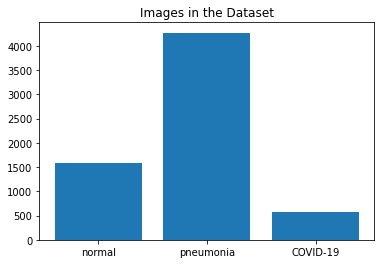

In [ ]:
num_tr_c = len(os.listdir(train_c_dir))
num_test_c = len(os.listdir(test_c_dir))
num_val_c = len(os.listdir(val_c_dir))

num_tr_n = len(os.listdir(train_n_dir))
num_test_n = len(os.listdir(test_n_dir))
num_val_n = len(os.listdir(val_n_dir))

num_tr_p = len(os.listdir(train_p_dir))
num_test_p = len(os.listdir(test_p_dir))
num_val_p = len(os.listdir(val_p_dir))

tr_val_c = num_tr_c + num_val_c
tr_val_n = num_tr_n + num_val_n
tr_val_p = num_tr_p + num_val_p

total_c = num_tr_c + num_val_c + num_test_c
total_n = num_tr_n + num_val_n + num_test_n
total_p = num_tr_p + num_val_p + num_test_p

print(tr_val_c, tr_val_n, tr_val_p)
print(total_c, total_n, total_p)

labels=["normal","pneumonia","COVID-19"]
plt.bar(labels,[total_n,total_p,total_c])
plt.title("Images in the Dataset")

Assigning Weights to Balance the chosen Dataset

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

total_images = total_c + total_n + total_p

c_dataset_weight = (total_images/3)*(1/total_c)
p_dataset_weight = (total_images/3)*(1/total_p)
n_dataset_weight = (total_images/3)*(1/total_n)
print(c_dataset_weight)
print(p_dataset_weight)
print(n_dataset_weight)

3.722222222222222
0.5017552071144395
1.3543903979785217


In [ ]:
weights_dictionary = { 0:c_dataset_weight, 1:n_dataset_weight, 2:p_dataset_weight}

### Prepare data for training

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_set = train_datagen.flow_from_directory( train_dir, target_size=(224,224), batch_size=64, shuffle=True)
test_set = test_datagen.flow_from_directory( test_dir, target_size=(224,224), batch_size=64, shuffle=True)
val_set = val_datagen.flow_from_directory( val_dir, target_size=(224,224), batch_size=64, shuffle=True)

Found 3860 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.
Found 1287 images belonging to 3 classes.


In [ ]:
# train_set.image_shape
print(train_set.image_shape)
print(test_set.image_shape)
print(val_set.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


The batch size and image size:  (64, 224, 224, 3)


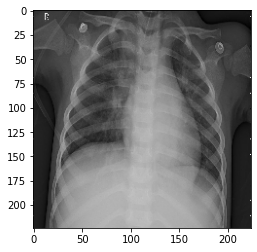

In [ ]:
# https://stackoverflow.com/questions/59217031/plot-images-from-image-generator
img=(next(val_set)[0])/255.0
print('The batch size and image size: ', img.shape)
plt.imshow(np.squeeze(img)[0])

In [ ]:
train_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

### Model Creation - Vanilla CNN

In [ ]:
def cnn_build_model():
  tf.random.set_seed(SEED)
  model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(input_shape=(224, 224, 3), filters=32, kernel_size=3, padding="same",activation='relu'),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2), 
	  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
	  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=3, activation='softmax')
  ])

  return model

In [ ]:
cnn = cnn_build_model()
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     36992     
                                                                 
 batch_normalization_4 (Batc  (None, 112, 112, 128)    512       
 hNormalization)                                                 
                                                      

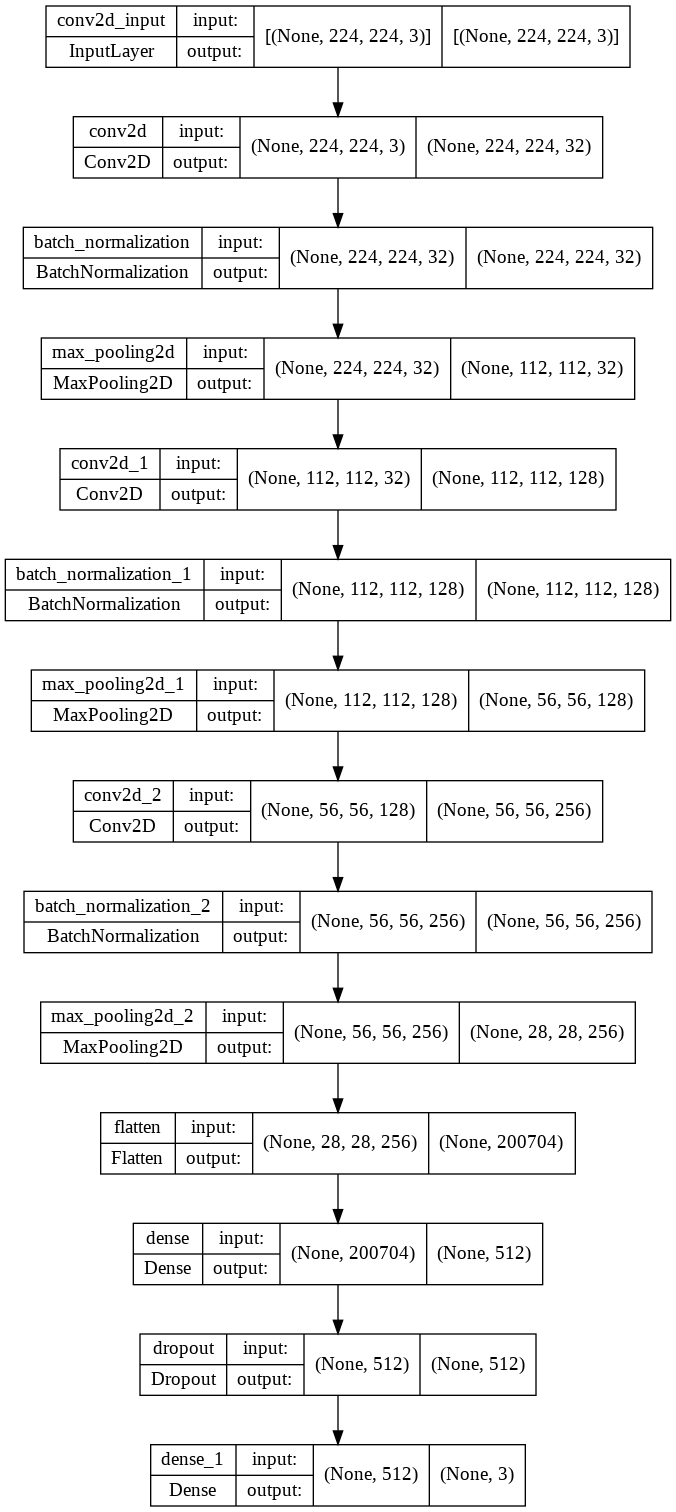

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
plot_model(cnn, show_shapes=True)

In [ ]:
#Number of layers in Vanila CNN
n_layers_cnn=len(cnn.layers)
print('Number of layers',n_layers_cnn)

Number of layers 13


In [ ]:
cnn.output

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_1')>

#### Compile model

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
learning_rate=0.001
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
cnn.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

#### Train Vanilla CNN

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduce=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3)

history=cnn.fit(x=train_set,validation_data=val_set,epochs=30,callbacks=[lr_reduce, early_stopping],class_weight = weights_dictionary)

Epoch 1/30
121/121 [==============================] - 112s 922ms/step - loss: 0.0229 - accuracy: 0.9894 - val_loss: 0.2478 - val_accuracy: 0.9588 - lr: 2.4010e-04
Epoch 2/30
121/121 [==============================] - 110s 908ms/step - loss: 0.0234 - accuracy: 0.9889 - val_loss: 0.2762 - val_accuracy: 0.9448 - lr: 2.4010e-04
Epoch 3/30
121/121 [==============================] - 110s 905ms/step - loss: 0.0195 - accuracy: 0.9922 - val_loss: 0.2698 - val_accuracy: 0.9565 - lr: 2.4010e-04
Epoch 4/30
121/121 [==============================] - 110s 909ms/step - loss: 0.0203 - accuracy: 0.9907 - val_loss: 0.3004 - val_accuracy: 0.9549 - lr: 2.4010e-04
Epoch 5/30
121/121 [==============================] - 110s 914ms/step - loss: 0.0232 - accuracy: 0.9917 - val_loss: 0.2547 - val_accuracy: 0.9487 - lr: 1.6807e-04
Epoch 6/30
121/121 [==============================] - 111s 914ms/step - loss: 0.0147 - accuracy: 0.9927 - val_loss: 0.3346 - val_accuracy: 0.9557 - lr: 1.6807e-04
Epoch 7/30
121/121 [==

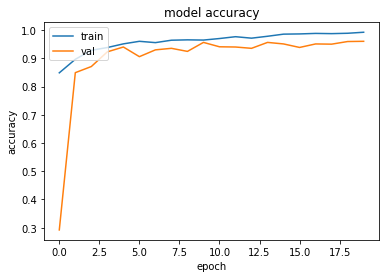

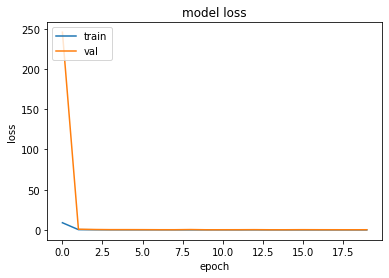

In [ ]:
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_loss=cnn.evaluate(test_set)

21/21 [==============================] - 974s 49s/step - loss: 0.3212 - accuracy: 0.9525


In [ ]:
# https://medium.com/@scueval07/covid-resnet-covid-19-detection-in-chest-x-ray-a11a4f72c490
batches=math.ceil(test_set.samples/test_set.batch_size)

for batch in range(batches):
  if batch==0:
    x_test,y_test = next(test_set)
  else:
    x_batch,y_batch=next(test_set)
    x_test=np.vstack((x_test,x_batch))
    y_test=np.vstack((y_test,y_batch))
      
labels=np.argmax(y_test,axis=-1)
class_indices=test_set.class_indices

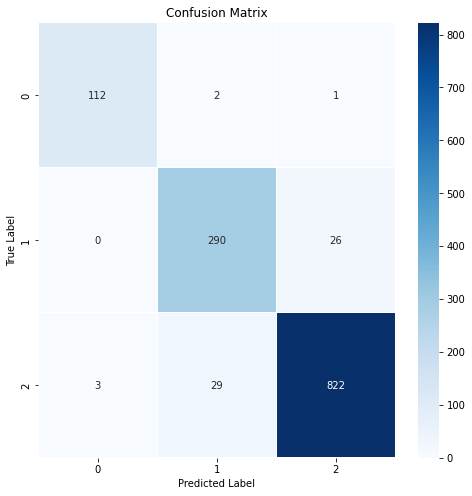

In [ ]:
y_pred = cnn.predict(x_test)
y_pred_test = np.argmax(y_pred, axis=1)
y_test_np = np.argmax(y_test, axis=1)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
confusion_mtx = confusion_matrix(y_test_np, y_pred_test)
f, ax = plt.subplots(figsize=(8,8))
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("test data samples",len(test_set.classes))
print("predicted data samples",len(y_pred_test))
print("Shape of Predicted Value",y_pred_test.shape)
print("Shape of actual Value",test_set.classes.shape)

test data samples 1285
predicted data samples 1285
Shape of Predicted Value (1285,)
Shape of actual Value (1285,)


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test_np, y_pred_test, target_names=["covid-19","normal",'pneumonia']))

              precision    recall  f1-score   support

    covid-19       0.97      0.97      0.97       115
      normal       0.90      0.92      0.91       316
   pneumonia       0.97      0.96      0.97       854

    accuracy                           0.95      1285
   macro avg       0.95      0.95      0.95      1285
weighted avg       0.95      0.95      0.95      1285



## Model Creation - VGG16

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

from keras.applications.vgg16 import VGG16

pre_trained_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def vgg16_build_model():
  tf.random.set_seed(SEED)
  model = tf.keras.Sequential([ 
    pre_trained_vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=3, activation='softmax')
  ])
  
  return model

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_model = vgg16_build_model()
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 27,561,795
Trainable params: 27,561,795
Non-trainable params: 0
_________________________________________________________________


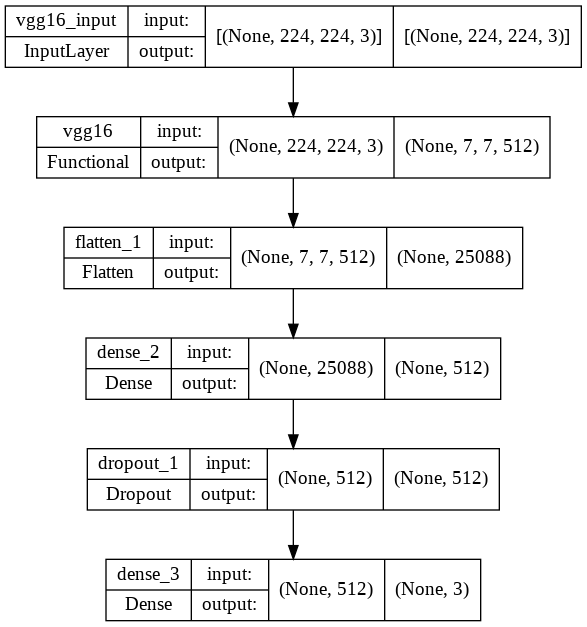

In [ ]:
plot_model(vgg16_model,show_shapes=True)

In [ ]:
n_layers_vgg16=len(vgg16_model.layers)
print('Number of layers',n_layers_vgg16)

#Number of total CovidResnet layers
# print('Number of total CovidResnet layers:',len(vgg16_model.layers)+n_layers_resnet-1)

Number of layers 5


In [ ]:
vgg16_model.output

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_3')>

#### Compile model

In [ ]:
learning_rate=0.001
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
vgg16_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduce=tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3)

history=vgg16_model.fit(x=train_set,validation_data=val_set,epochs=30,callbacks=[lr_reduce, early_stopping])

Epoch 1/30
61/61 [==============================] - 130s 2s/step - loss: 3.8251 - accuracy: 0.6601 - val_loss: 0.6830 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 2/30
61/61 [==============================] - 114s 2s/step - loss: 0.5166 - accuracy: 0.7969 - val_loss: 0.5436 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 3/30
61/61 [==============================] - 115s 2s/step - loss: 0.4400 - accuracy: 0.8329 - val_loss: 0.4578 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 4/30
61/61 [==============================] - 115s 2s/step - loss: 0.3233 - accuracy: 0.8764 - val_loss: 0.3029 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 5/30
61/61 [==============================] - 116s 2s/step - loss: 0.3149 - accuracy: 0.8821 - val_loss: 0.2933 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 6/30
61/61 [==============================] - 116s 2s/step - loss: 0.4213 - accuracy: 0.8560 - val_loss: 0.2587 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 7/30
61/61 [==============================] - 116s 2s/step - loss: 0.2

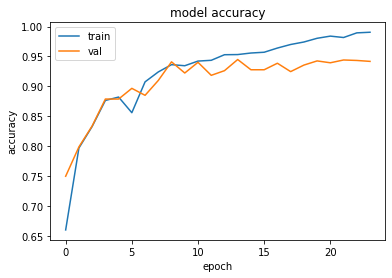

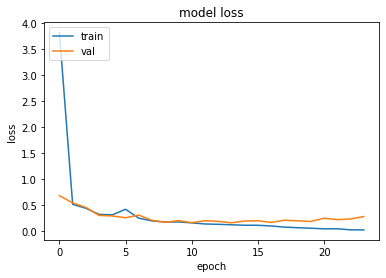

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing

In [ ]:
test_loss=vgg16_model.evaluate(test_set)

21/21 [==============================] - 28s 1s/step - loss: 0.3534 - accuracy: 0.9447


### Confusion Matrix

In [ ]:
# https://medium.com/@scueval07/covid-resnet-covid-19-detection-in-chest-x-ray-a11a4f72c490
batches=math.ceil(test_set.samples/test_set.batch_size)

for batch in range(batches):
  if batch==0:
    x_test,y_test = next(test_set)
  else:
    x_batch,y_batch=next(test_set)
    x_test=np.vstack((x_test,x_batch))
    y_test=np.vstack((y_test,y_batch))
      
labels=np.argmax(y_test,axis=-1)
class_indices=test_set.class_indices

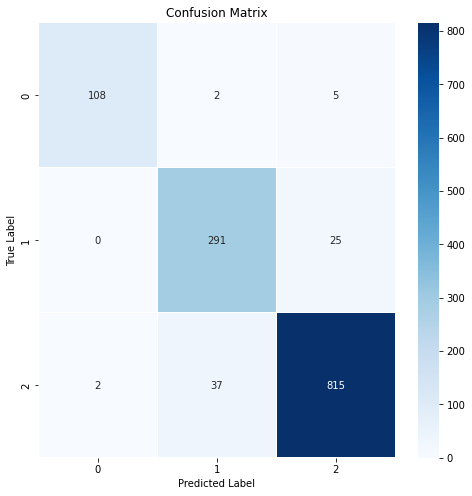

In [ ]:
y_pred = vgg16_model.predict(x_test)
y_pred_test = np.argmax(y_pred, axis=1)
y_test_np = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test_np, y_pred_test)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt="d",ax=ax, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("test data samples",len(test_set.classes))
print("predicted data samples",len(y_pred_test))
print("Shape of Predicted Value",y_pred_test.shape)
print("Shape of actual Value",test_set.classes.shape)

test data samples 1285
predicted data samples 1285
Shape of Predicted Value (1285,)
Shape of actual Value (1285,)


In [ ]:
print(classification_report(y_test_np, y_pred_test, target_names=["covid-19","normal",'pneumonia']))

              precision    recall  f1-score   support

    covid-19       0.98      0.94      0.96       115
      normal       0.88      0.92      0.90       316
   pneumonia       0.96      0.95      0.96       854

    accuracy                           0.94      1285
   macro avg       0.94      0.94      0.94      1285
weighted avg       0.95      0.94      0.95      1285



## VGG19

### Model Creation



In [ ]:
pre_trained_vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# pre_trained_vgg19 = tf.keras.applications.VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))

def vgg19_build_model():
  
  tf.random.set_seed(SEED)
  
  model = tf.keras.Sequential([ 
    pre_trained_vgg19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=3, activation='softmax')
  ])
  
  return model

80150528/80134624 [==============================] - 4s 0us/step


In [ ]:
vgg19_model = vgg19_build_model()
vgg19_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 32,871,491
Trainable params: 32,871,491
Non-trainable params: 0
_________________________________________________________________


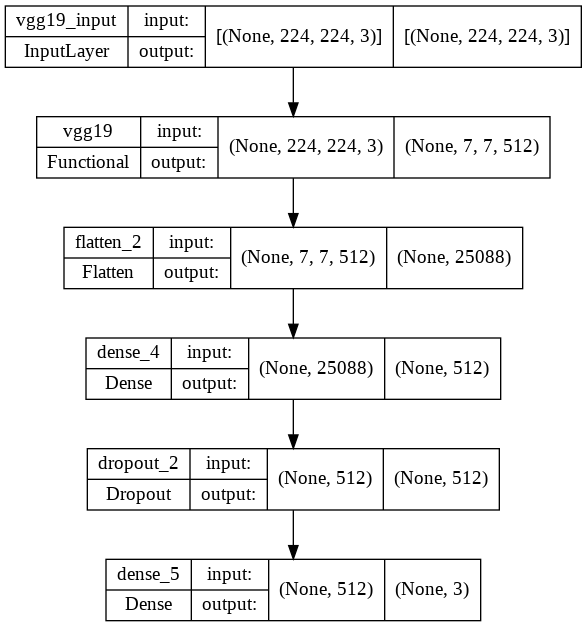

In [ ]:
plot_model(vgg19_model, show_shapes=True)

In [ ]:
n_layers_vgg19=len(vgg19_model.layers)
print('Number of layers',n_layers_vgg19)

Number of layers 5


In [ ]:
vgg19_model.output

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_5')>

In [ ]:
learning_rate=0.001
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
vgg19_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_reduce=tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3)

history=vgg19_model.fit(x=train_set,validation_data=val_set,epochs=30,callbacks=[lr_reduce, early_stopping])

Epoch 1/30
61/61 [==============================] - 120s 2s/step - loss: 8.8935 - accuracy: 0.6168 - val_loss: 0.8183 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 2/30
61/61 [==============================] - 117s 2s/step - loss: 0.8206 - accuracy: 0.6611 - val_loss: 0.7685 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/30
61/61 [==============================] - 117s 2s/step - loss: 0.6524 - accuracy: 0.7085 - val_loss: 0.6146 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 4/30
61/61 [==============================] - 117s 2s/step - loss: 0.4591 - accuracy: 0.8111 - val_loss: 0.4947 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 5/30
61/61 [==============================] - 118s 2s/step - loss: 0.3371 - accuracy: 0.8640 - val_loss: 0.3650 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 6/30
61/61 [==============================] - 123s 2s/step - loss: 0.2542 - accuracy: 0.9031 - val_loss: 0.2573 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 7/30
61/61 [==============================] - 126s 2s/step - loss: 0.2

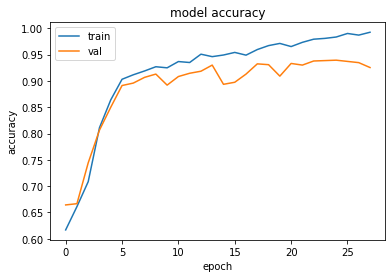

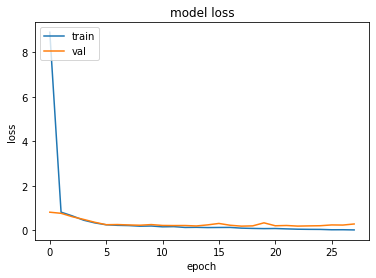

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_loss=vgg19_model.evaluate(test_set)

21/21 [==============================] - 27s 1s/step - loss: 0.2822 - accuracy: 0.9393


In [ ]:
batches=math.ceil(test_set.samples/test_set.batch_size)

for batch in range(batches):
  if batch==0:
    x_test,y_test = next(test_set)
  else:
    x_batch,y_batch=next(test_set)
    x_test=np.vstack((x_test,x_batch))
    y_test=np.vstack((y_test,y_batch))
      
labels=np.argmax(y_test,axis=-1)
class_indices=test_set.class_indices

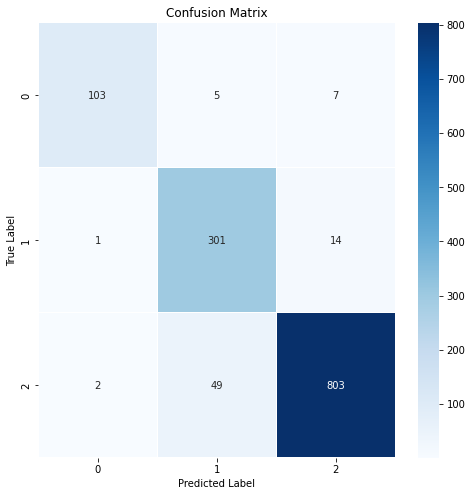

In [ ]:
y_pred = vgg19_model.predict(x_test)
y_pred_test = np.argmax(y_pred, axis=1)
y_test_np = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test_np, y_pred_test)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt="d",ax=ax, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("test data samples",len(test_set.classes))
print("predicted data samples",len(y_pred_test))
print("Shape of Predicted Value",y_pred_test.shape)
print("Shape of actual Value",test_set.classes.shape)

test data samples 1285
predicted data samples 1285
Shape of Predicted Value (1285,)
Shape of actual Value (1285,)


In [ ]:
print(classification_report(y_test_np, y_pred_test, target_names=["covid-19","normal",'pneumonia']))

              precision    recall  f1-score   support

    covid-19       0.97      0.90      0.93       115
      normal       0.85      0.95      0.90       316
   pneumonia       0.97      0.94      0.96       854

    accuracy                           0.94      1285
   macro avg       0.93      0.93      0.93      1285
weighted avg       0.94      0.94      0.94      1285

